In [3]:
from src import kernel

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1

# Kernel ABC

## Simple dataset

離散的な、階段関数をmodelとする。

In [4]:
def SimModel(x,param):
    y = (x*0.2).astype(int)*param[0] + param[1]*np.sqrt(x).astype(int)
    return y

In [6]:
X = np.arange(0,50,1.)
Y_obs = SimModel(X,[2,10])

obs_data = pd.DataFrame({'x':X,'y':Y_obs})

param_set = []
np.random.seed(1)
for i in range(30):
    param_set.append([float(np.random.randint(0,20)),float(np.random.randint(0,20))])

df = pd.DataFrame()
for i,param in enumerate(param_set):
    
    Y = SimModel(X,param)
    df = pd.concat([df,pd.DataFrame({'x':X.astype(float),
                                     'y':Y.astype(float),
                                     'para0':float(param[0]),
                                     'para1':float(param[1])})])

In [7]:
dataset = kernel.utils.ABCDataSet(prior_samples=df,
                                  parameter_keys=['para0','para1'],
                                  observed_samples=obs_data,
                                  data_key=['y'])

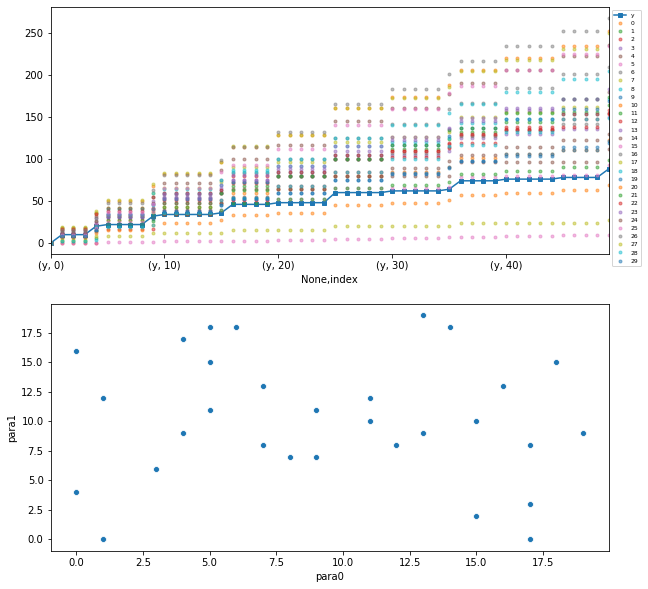

In [8]:
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(211)
dataset.observed_samples.T.plot(marker='s',ax=ax1,ms=4,legend=False)
dataset.prior_data.T.plot(marker='o',linestyle='',ax=ax1,alpha=0.5,ms=3,legend=False)
ax1.legend(bbox_to_anchor=(1,1),loc='upper left',fontsize=6)

ax2 = fig.add_subplot(212)
sns.scatterplot(data=dataset.parameters,x='para0',y='para1')
fig.show()

# KernelABC 
observed dataを観測した時のposteriorを計算する。

In [9]:
ABC = kernel.ABC(Dataset=dataset,
                 sigma_y='silverman',
                 sigma_para='silverman')

In [10]:
KM_prior = kernel.Mean(ABC.Dataset.parameters,sigma='silverman')
KM_post = ABC.posterior_kernel()
x = np.arange(0,19.,1.)
y = np.arange(0,19.,1.)
xx,yy = np.meshgrid(x,y)
z_prior = KM_prior.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
z_prior = z_prior.reshape(xx.shape[0],-1)
z_post = KM_post.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
z_post = z_post.reshape(xx.shape[0],-1)

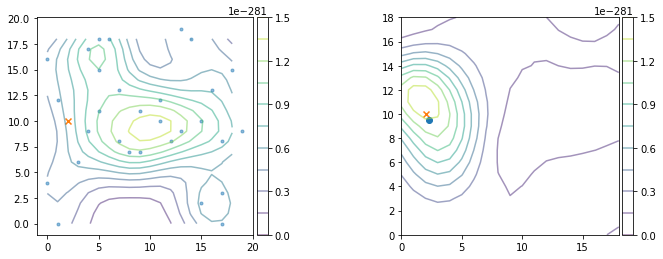

In [11]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)
cbar1 = ax1.contour(xx,yy,z_prior,10,alpha=0.5)
ax1.scatter(
    ABC.Dataset.parameters.loc[:,'para0'],
    ABC.Dataset.parameters.loc[:,'para1'],
    alpha=0.5,marker='.')
ax1.scatter(2,10,marker='x')
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)

ax2 = fig.add_subplot(122)
cbar2 = ax2.contour(xx,yy,z_post,10,alpha=0.5)
ax2.scatter(2,10,marker='x',label='True',color='C1')
ax2.scatter(ABC.posterior_mean().para0,
            ABC.posterior_mean().para1,
            marker='o',label='predict')
ax2.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)
fig.show()

左が、prior. orangeの点が正解になって欲しい。右が,posterior.

# kernel Herding
posterior からサンプル

In [12]:
KH = kernel.Herding(obj_KernelMean=ABC.posterior_kernel())

In [13]:
supersample = KH.supersample(
                sample_size=100, 
                optimizer='scipy_optim',method='powell')

'    100% |################################| 0day  0:00:00 Total time: 0day  0:00:05'

In [14]:
z_post_herding = KH.approximation_mean(np.array([xx.ravel(),yy.ravel()]).T)
z_post_herding = z_post_herding.reshape(xx.shape[0],-1)

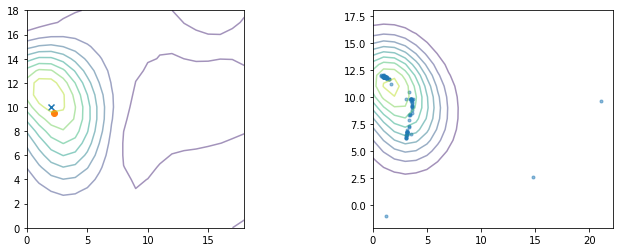

In [15]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)
cbar1 = ax1.contour(xx,yy,z_post,10,alpha=0.5)
ax1.scatter(2,10,marker='x')
ax1.scatter(ABC.posterior_mean().para0,
            ABC.posterior_mean().para1,
            marker='o',label='predict')
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
#cax = divider.new_horizontal(size="5%", pad=0.05)
#fig.add_axes(cax)
#fig.colorbar(cbar1,cax=cax)

ax2 = fig.add_subplot(122)
cbar2 = ax2.contour(xx,yy,z_post_herding,10,alpha=0.5)
ax2.scatter(
    supersample[:,0],
    supersample[:,1],
    alpha=0.5,marker='.')

ax2.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
cax = divider.new_horizontal(size="5%", pad=0.05)
#fig.add_axes(cax)
#fig.colorbar(cbar1,cax=cax)
fig.show()

サンプスされた点が右図

# plot data from posterior samples

array([2.25856929, 9.53107705])

In [35]:
df_pred = pd.DataFrame()
for i,param in enumerate(supersample):
    
    Y = SimModel(X,param)
    df_pred = pd.concat([df_pred,
                         pd.DataFrame({'x':X.astype(float),
                                       'y':Y.astype(float),
                                       'para0':float(param[0]),
                                       'para1':float(param[1])})])
    
Y_mean = SimModel(X,ABC.posterior_mean().values[0])

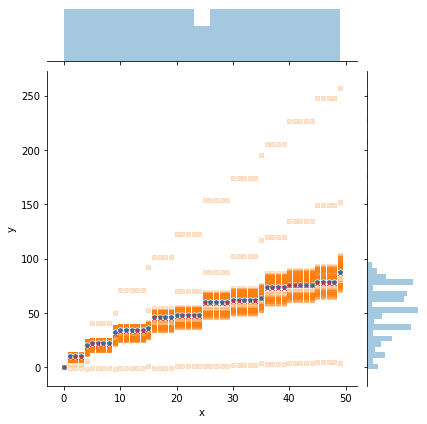

In [40]:
g = sns.jointplot(x="x", y="y", data=df_pred)
g.plot_joint(plt.scatter, c="C1", s=20, linewidth=1, marker="s",alpha=0.2)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
sns.scatterplot(obs_data.x,obs_data.y,marker='o',s=30)
sns.scatterplot(X,Y_mean,marker='x',s=20,color='C3')

二つに別れて見えるのは、herdingサンプルが二つにクラスタリングされてしまった為だろう。   
meanはほぼobsと重なっている。